In [12]:
import websockets
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *

In [13]:
endereco_robo="dohko" # Substitua pelo endereço do robô se necessário
porta_servico="8087"
async with websockets.connect(f"ws://{endereco_robo}:{porta_servico}/wsctrl") as websocket:
    await websocket.send("ack")
    res = json.loads(await  websocket.recv())

ConnectionRefusedError: [Errno 111] Connect call failed ('192.168.7.230', 8087)

NameError: name 'res' is not defined

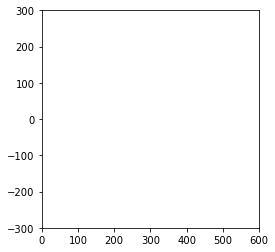

In [15]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0,600)
ax.set_ylim(-300,300)
for x, y in res["coordenadas"]:
    c = mpatches.Circle((x,y), radius=12)
    ax.add_patch(c)

In [17]:
def getboottime():
    times = []
    for i in range(40):
        t2 = time.clock_gettime(time.CLOCK_REALTIME)
        t1 = time.clock_gettime(time.CLOCK_MONOTONIC)
        times.append(t2-t1)
        t1 = time.clock_gettime(time.CLOCK_MONOTONIC)
        t2 = time.clock_gettime(time.CLOCK_REALTIME)
        times.append(t2-t1)

    times.sort()
    tot = 0.0
    for i in range(15,25):
        tot += times[i]
    return tot/10
    
class Detector():
    def __init__(self, min_radius, max_radius, scale=1.0):
        # Parâmetros minRadius e maxRadius
        self._min_radius = np.int32(np.floor(min_radius*scale))
        self._max_radius = np.int32(np.ceil(max_radius*scale))

        self._vid = cv2.VideoCapture(0, cv2.CAP_V4L2)
        self._vid.set(cv2.CAP_PROP_AUTOFOCUS,0)
        self._vid.set(cv2.CAP_PROP_FOCUS,0)
        self._vid.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
        self._vid.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
        self._boot_time = getboottime()*1000000000
        self._prev_frame_ts = time.time()
        self._scale=1
        self.mapa_x, self.mapa_y = mapa_x,mapa_y

        # TODO:
        # Inicialize o mapa de reprojeção da imagem
        #   e a matriz de transformação de coordenadas de imagem para robô
        self._itrans_matrix = Q  # Substitua None pela matriz que transforma coordenadas da imagem
                                    # em coordenadas do robô

    def detecta(self):
            frame = cv2.imread("../images/4circulos_v2.jpg")
            ts = int((self._vid.get(cv2.CAP_PROP_POS_MSEC)*1000000)+self._boot_time)
            # Imagem em tons de cinza
            img_cinza = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            borda = cv2.BORDER_CONSTANT
            # tipos de borda:
            # cv2.BORDER_CONSTANT
            # cv2.BORDER_REFLECT
            # cv2.BORDER_REFLECT_101
            # cv2.BORDER_REPLICATE
            # cv2.BORDER_WRAP
            img_remapeada = cv2.remap(img_cinza, self.mapa_x, self.mapa_y, cv2.INTER_LINEAR, borderMode=borda)
            #plt.imshow(img_cinza)
            plt.imshow(img_remapeada)
            img_blur = cv2.medianBlur(img_remapeada,5)
            method=cv2.HOUGH_GRADIENT
            dp=1
            minDist=20*self._scale
            param1=100
            param2=15
            minRadius=self._min_radius
            maxRadius=self._max_radius
            circles = cv2.HoughCircles ( img_blur , method , dp , minDist , param1 , param2 , minRadius , maxRadius )

            # TODO:
            # 1. Remapeie a imagem
            # 2. Aplique cv2.medianBlur(imagem, 5)
            # 3. Detecte círculos com HoughCircles.
            #       use method = cv2.HOUGH_GRADIENT, param1=100 e param2=15
            #       Os parâmetros minRadius e maxRadius estão no objeto

            circles = circles  # Substitua pelo resultado da chamada a HoughCircles
            coordenadas = []
            if circles is not None:
                for c in circles[0, :]:
                    coordnumpy = self._itrans_matrix.dot(np.float32([c[0], c[1], 1.0]))
                    coordenadas.append([float(coordnumpy[0]), float(coordnumpy[1])])
                ncircles = len(circles[0, :])
            else:
                ncircles = 0
            t = time.time()
            print("n: " + str(ncircles) + " FPS: " + str(1/(t-self._prev_frame_ts)) + " lag: " + str(time.time() - ts/1000000000), end="\r")
            self._prev_frame_ts = t
            return coordenadas, ts

([[-147.56799925811097, -164.62204889987152],
  [-148.3575766504963, -447.63269491926036],
  [-156.91538870005596, -165.69330644485993],
  [-156.61307513993472, -190.6914112160636],
  [-168.4780881594683, -215.78224934764958],
  [-91.46897655115184, -1088.2096011436865],
  [-155.43045366014113, -133.68146566689114],
  [-143.95358937625278, -192.59495956967058],
  [-85.41676845527735, -1008.1621658602297],
  [-139.38142096853002, -454.56439756876415],
  [-140.89907149958918, -135.57074734967006],
  [-87.22456708555147, -1052.1766635960832],
  [-139.86512266472394, -414.56742993483823],
  [-130.37024795654065, -193.49145039701537],
  [-177.25594072969534, -147.84803772099477],
  [-149.34916512769385, -365.63891126971225],
  [-147.82550478468295, -491.6293593165788],
  [-151.38916973954164, -235.6523331271601],
  [-89.33104422137521, -1110.1936666715176],
  [-0.7679823154853072, -422.5074473434891],
  [-83.32238386185844, -949.1452385939469],
  [-139.11538503562335, -476.5627297674234],
 

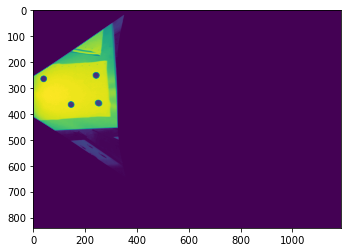

In [18]:
a = Detector(9,15,scale=1)
a.detecta()